In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
import sys
sys.path.append('/share/u/wendler/code/my-sdxl-unbox')

In [2]:
n = 100
path_to_checkpoints = '../checkpoints/'
k = 160
exp = 4
n_timesteps = 4
use_vanilla = True

In [3]:
outfile = f"timestep_generalization_n{n}_t{n_timesteps}_{'vanilla' if use_vanilla else 'turbo'}_k{k}_exp{exp}.csv"

In [4]:
n_feats = exp * 1280

In [5]:
import os
import gradio as gr
import torch
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from app import create_demo
assert torch.cuda.is_available(), "Your machine has no access to GPU. If you are using Colab, consider changing environment"
# The SAEs were trained to work with torch.float32, but they can also work with torch.float16
# Change this value to torch.float32 if you have access to a GPU with >30GB of memory
dtype=torch.float16
dtype=torch.float32

sdxl_turbo = "stabilityai/sdxl-turbo" 
sdxl = "stabilityai/stable-diffusion-xl-base-1.0"
if not use_vanilla:
    model_name = sdxl_turbo 
else:
    model_name = sdxl

pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
path_to_checkpoints = '../hparam_study/'

code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{n_feats}_auxk256_bs4096_lr0.0001", "final"),
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import json
if n > 5:
    with open('/tmp/wendler/first_50K_prompts.json', 'r') as f:
        prompts = json.load(f)
    prompts = [p["caption"] for p in prompts[:n]]
else:
    prompts = [
        "A photo of a cat",
        "A photo of a dog",
        "A photo of a bird",
        "A photo of a fish",
        "A photo of a horse",
    ]

In [14]:
prompts

['The Ferrari GTS is driving down the street.',
 'An antique chandelier with five lights.',
 'Three men in suits and hats standing next to each other.',
 'A man in a fur vest and hat holding a microphone.',
 'A couple is standing in the water at sunset.',
 'A man in glasses and suit speaking into a microphone.',
 'An older man and woman are looking at something.',
 'The white truck is parked in the parking lot.',
 'A woman wearing a black hat with a large bow.',
 'Three little remedies for kids: saline spray.',
 'A bed with white and red bedspread in a bedroom.',
 'The characters are riding horses in the snow.',
 'Two framed pictures hanging on the wall next to each other.',
 'An airplane flying in the sky with its landing gear down.',
 'A man is digging in the ground to install a fence.',
 'An orange and white google home speaker next to a gray google assistant.',
 'A man in camouflage holding his camera and talking on the phone.',
 'Two women in gold dresses posing for the camera.',


In [15]:
# find out the models inside of pipe
if dtype == torch.float32:
    pipe.text_encoder.to(dtype=torch.float32)
    pipe.text_encoder_2.to(dtype=torch.float32)

In [16]:
from collections import defaultdict


In [ ]:
sys.path.append('/share/u/wendler/code/my-sdxl-unbox/scripts')
from train_sae import explained_variance
from tqdm import tqdm
verbose = False
results = defaultdict(list)
for pidx, prompt in enumerate(tqdm(prompts)):
    output, cache = pipe.run_with_cache(
        prompt,
        positions_to_cache=list(code_to_block.values()),
        save_input=True,
        save_output=True,
        num_inference_steps=n_timesteps,
        guidance_scale=0.0 if not use_vanilla else 7.5,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )
    timesteps = pipe.scheduler.timesteps
    if verbose:
        plt.imshow(output.images[0])
        plt.show()
    for short, long in code_to_block.items():
        diff = cache['output'][long][0] - cache['input'][long][0]
        # timesteps x features x height x width
        #gprint(short, sae.path)
        sae = saes_dict[short]
        diff_flat = diff.permute(0, 2, 3, 1) # 
        # timesteps x height x width x features
        diff_flat = diff_flat.reshape(-1, diff.shape[1])
        # (timesteps * height * width) x features
        recon, info = sae(diff_flat)
        # (timesteps * height * width) x features
        mse = ((recon - diff_flat)**2).mean()
        recon = recon.reshape(len(timesteps), -1, recon.shape[1]) # this guy breaks things
        # timesteps x (height * width) x features
        for idx in range(diff.shape[0]):
            tmp = diff[idx].permute(1,2,0).reshape(-1, diff_flat.shape[1])
            mse2 = ((recon[idx] - tmp)**2).mean()
            # expects n x features
            explained_var = explained_variance(diff[idx].permute(1,2,0).reshape(-1, diff.shape[1]), recon[idx])
            results["block"].append(short)
            results["prompt"].append(prompt)
            results["tidx"].append(idx)
            results["t"].append(timesteps[idx].item())
            results["mse"].append(mse2.item())
            results["explained_var"].append(explained_var.item())
from pandas import DataFrame
df = DataFrame(results)
df.to_csv(outfile)
df

down.2.1 ../hparam_study/unet.up_blocks.0.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
mid.0 ../hparam_study/unet.down_blocks.2.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.1 ../hparam_study/unet.mid_block.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
down.2.1 ../hparam_study/unet.up_blocks.0.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
mid.0 ../hparam_study/unet.down_blocks.2.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.1 ../hparam_study/unet.mid_block.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
down.2.1 ../hparam_study/unet.up_blocks.0.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
mid.0 ../hparam_study/unet.down_blocks.2.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.

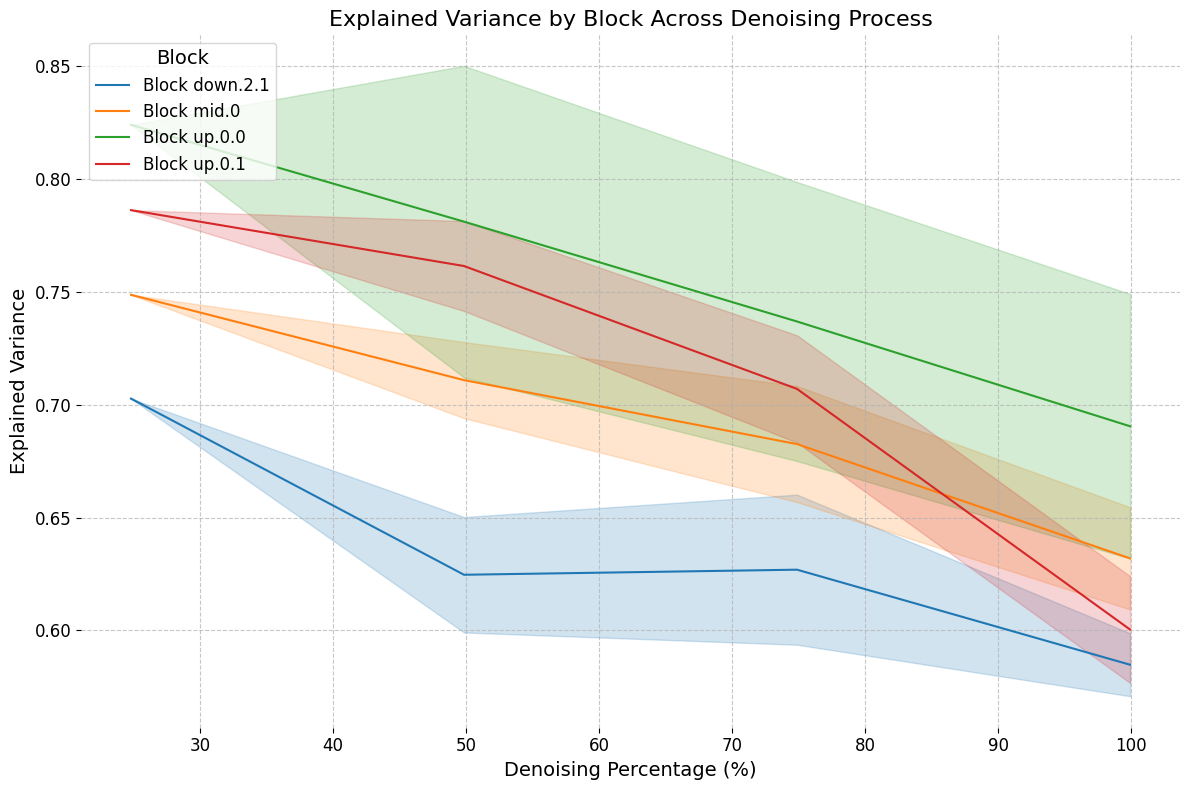

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by block and timestep to get mean and std of explained variance
summary_df = df.groupby(["block", "t"])["explained_var"].agg(['mean', 'std']).reset_index()

# Calculate denoising percentage (999 = 0%, 0 = 100%)
max_t = 999  # Based on the data, 999 is the maximum timestep
summary_df['denoising_percent'] = 100 * (1 - summary_df['t'] / max_t)

plt.figure(figsize=(12, 8))
# Remove border
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

blocks = summary_df['block'].unique()
colors = sns.color_palette(n_colors=len(blocks))

for i, block in enumerate(blocks):
    block_df = summary_df[summary_df['block'] == block]
    plt.plot(block_df['denoising_percent'], block_df['mean'], label=f"Block {block}", color=colors[i])
    # Gaussian confidence interval: mean ± 1.96*std
    lower = block_df['mean'] - 1.96 * block_df['std']
    upper = block_df['mean'] + 1.96 * block_df['std']
    plt.fill_between(block_df['denoising_percent'], lower, upper, color=colors[i], alpha=0.2)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Increase font size
plt.title("Explained Variance by Block Across Denoising Process", fontsize=16)
plt.xlabel("Denoising Percentage (%)", fontsize=14)
plt.ylabel("Explained Variance", fontsize=14)
plt.legend(title="Block", loc='upper left', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
df

,block,prompt,tidx,t,mse,explained_var
0,down.2.1,A photo of a cat,0,751.0,0.534309,0.702703
1,down.2.1,A photo of a cat,1,501.0,0.647584,0.637465
2,down.2.1,A photo of a cat,2,251.0,0.781892,0.651103
3,down.2.1,A photo of a cat,3,1.0,0.943732,0.595352
4,mid.0,A photo of a cat,0,751.0,2.018207,0.748674
...,...,...,...,...,...,...
75,up.0.1,A photo of a horse,3,1.0,3.347485,0.582475
76,up.0.0,A photo of a horse,0,751.0,1.330956,0.823964
77,up.0.0,A photo of a horse,1,501.0,2.054717,0.810874
78,up.0.0,A photo of a horse,2,251.0,2.119906,0.765306


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by block and tidx to get mean and std of explained variance
summary_df = df.groupby(["block", "tidx"])["explained_var"].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 8))
# Remove border
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

blocks = summary_df['block'].unique()
colors = sns.color_palette(n_colors=len(blocks))

for i, block in enumerate(blocks):
    block_df = summary_df[summary_df['block'] == block]
    plt.plot(block_df['tidx'], block_df['mean'], label=f"Block {block}", color=colors[i])
    # Gaussian confidence interval: mean ± 1.96*std
    lower = block_df['mean'] - 1.96 * block_df['std']
    upper = block_df['mean'] + 1.96 * block_df['std']
    plt.fill_between(block_df['tidx'], lower, upper, color=colors[i], alpha=0.2)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Increase font size
plt.title("Explained Variance by Block Across Timestep Indices", fontsize=16)
plt.xlabel("Timestep Index (tidx)", fontsize=14)
plt.ylabel("Explained Variance", fontsize=14)
plt.legend(title="Block", loc='upper left', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()